# Hate Speech Modell Validierung

Dieses Notebook lädt das trainierte Modell und evaluiert es auf dem Validierungsdatensatz.

## Inhalte:
- Laden des trainierten Modells
- Laden des Validierungsdatensatzes
- Vorhersagen erstellen
- Confusion Matrix
- Classification Report
- ROC Curve
- Precision-Recall Curve
- Verschiedene Metriken und Visualisierungen


In [1]:
# Installation der benötigten Pakete
%pip install -q transformers torch pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Setze Style für bessere Visualisierungen
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Alle Pakete erfolgreich importiert")


c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Alle Pakete erfolgreich importiert


## 1. Modell und Tokenizer laden


In [3]:
# Pfad zum trainierten Modell
# Passe diesen Pfad an, falls dein Modell woanders gespeichert ist
MODEL_PATH = Path("../notebook/results_gbert-base_gahd_hatespeech_2025-11-04/final_model")

# Falls das Modell nicht existiert, suche nach anderen möglichen Pfaden
if not MODEL_PATH.exists():
    # Suche nach Modell-Verzeichnissen
    possible_paths = [
        Path("results_gbert-base_gahd_hatespeech_2025-11-04/final_model"),
        Path("../results_gbert-base_gahd_hatespeech_2025-11-04/final_model"),
        Path("notebook/results_gbert-base_gahd_hatespeech_2025-11-04/final_model"),
    ]
    for path in possible_paths:
        if path.exists():
            MODEL_PATH = path
            break

print(f"Lade Modell von: {MODEL_PATH}")

# Lade Tokenizer und Modell
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Setze Modell in Evaluationsmodus
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"✅ Modell erfolgreich geladen")
print(f"   Gerät: {device}")
print(f"   Anzahl Parameter: {sum(p.numel() for p in model.parameters()):,}")


Lade Modell von: ..\notebook\results_gbert-base_gahd_hatespeech_2025-11-04\final_model
✅ Modell erfolgreich geladen
   Gerät: cpu
   Anzahl Parameter: 109,929,218


## 2. Validierungsdatensatz laden


In [4]:
# Lade Validierungsdatensatz
val_df = pd.read_csv("../data/de_hf_112024_val.csv", encoding="utf-8")

# Bereinige Daten
val_df["text"] = val_df["text"].fillna("")
val_df["labels"] = val_df["labels"].astype(int)

print(f"✅ Validierungsdatensatz geladen")
print(f"   Anzahl Samples: {len(val_df):,}")
print(f"   Label-Verteilung:")
print(val_df["labels"].value_counts().sort_index())
print(f"\n   Anteil Hate Speech (Label 1): {val_df['labels'].mean()*100:.2f}%")
print(f"\n   Erste Zeilen:")
val_df.head()


✅ Validierungsdatensatz geladen
   Anzahl Samples: 2,528
   Label-Verteilung:
labels
0    2213
1     315
Name: count, dtype: int64

   Anteil Hate Speech (Label 1): 12.46%

   Erste Zeilen:


,text,labels
0,Siddhartha Gautama war doch einfach ein Träume...,0
1,"Ich würde es lieben, wenn sich alle Frauen ers...",1
2,"Danke Herr Lindner. Schade, dass die ""Meinungs...",0
3,"Die BILD schreibt: ""Duschen und nach Hause geh...",1
4,Man sollte Macron jetzt nicht im Regen stehen ...,0


## 3. Vorhersagen erstellen


In [5]:
# Erstelle Vorhersagen auf Validierungsdatensatz
print("Erstelle Vorhersagen...")

MAX_LEN = 512
batch_size = 32
y_true = val_df["labels"].values
y_pred = []
y_prob = []

with torch.no_grad():
    for i in range(0, len(val_df), batch_size):
        batch_texts = val_df["text"].iloc[i:i+batch_size].tolist()
        
        # Tokenisiere
        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        # Vorhersage
        outputs = model(**encodings)
        logits = outputs.logits
        
        # Softmax für Wahrscheinlichkeiten
        probs = torch.softmax(logits, dim=-1)
        predictions = torch.argmax(logits, dim=-1)
        
        y_prob.append(probs.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        
        if (i + batch_size) % 500 == 0:
            print(f"   Verarbeitet: {min(i + batch_size, len(val_df))}/{len(val_df)}")

y_pred = np.array(y_pred)
y_prob = np.vstack(y_prob)

print(f"\n✅ Vorhersagen abgeschlossen")
print(f"   y_true Verteilung: {np.bincount(y_true)}")
print(f"   y_pred Verteilung: {np.bincount(y_pred)}")


Erstelle Vorhersagen...

✅ Vorhersagen abgeschlossen
   y_true Verteilung: [2213  315]
   y_pred Verteilung: [2241  287]


## 4. Metriken berechnen


In [6]:
# Berechne Metriken
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Metriken pro Klasse
precision_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
recall_0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
f1_0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)

precision_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

# ROC AUC
roc_auc = roc_auc_score(y_true, y_prob[:, 1])

print("="*60)
print("VALIDIERUNGSERGEBNISSE")
print("="*60)
print(f"\n📊 Gesamtmetriken:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC AUC:   {roc_auc:.4f}")

print(f"\n📊 Metriken für Klasse 0 (Non-Hate):")
print(f"   Precision: {precision_0:.4f}")
print(f"   Recall:    {recall_0:.4f}")
print(f"   F1-Score:  {f1_0:.4f}")

print(f"\n📊 Metriken für Klasse 1 (Hate Speech):")
print(f"   Precision: {precision_1:.4f}")
print(f"   Recall:    {recall_1:.4f}")
print(f"   F1-Score:  {f1_1:.4f}")
print("="*60)


VALIDIERUNGSERGEBNISSE

📊 Gesamtmetriken:
   Accuracy:  0.9264
   Precision: 0.9239
   Recall:    0.9264
   F1-Score:  0.9249
   ROC AUC:   0.9169

📊 Metriken für Klasse 0 (Non-Hate):
   Precision: 0.9523
   Recall:    0.9643
   F1-Score:  0.9582

📊 Metriken für Klasse 1 (Hate Speech):
   Precision: 0.7247
   Recall:    0.6603
   F1-Score:  0.6910


## 5. Classification Report


In [7]:
# Detaillierter Classification Report
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=["Non-Hate (0)", "Hate Speech (1)"],
    output_dict=True,
    zero_division=0
)

print("Classification Report:")
print("="*60)
print(classification_report(
    y_true, y_pred,
    target_names=["Non-Hate (0)", "Hate Speech (1)"],
    zero_division=0
))
print("="*60)

# Erstelle DataFrame für bessere Visualisierung
report_df = pd.DataFrame(report).transpose()
report_df


Classification Report:
                 precision    recall  f1-score   support

   Non-Hate (0)       0.95      0.96      0.96      2213
Hate Speech (1)       0.72      0.66      0.69       315

       accuracy                           0.93      2528
      macro avg       0.84      0.81      0.82      2528
   weighted avg       0.92      0.93      0.92      2528



,precision,recall,f1-score,support
Non-Hate (0),0.952253,0.964302,0.958240,2213.000000
Hate Speech (1),0.724739,0.660317,0.691030,315.000000
accuracy,0.926424,0.926424,0.926424,0.926424
macro avg,0.838496,0.812310,0.824635,2528.000000
weighted avg,0.923904,0.926424,0.924944,2528.000000


## 6. Confusion Matrix


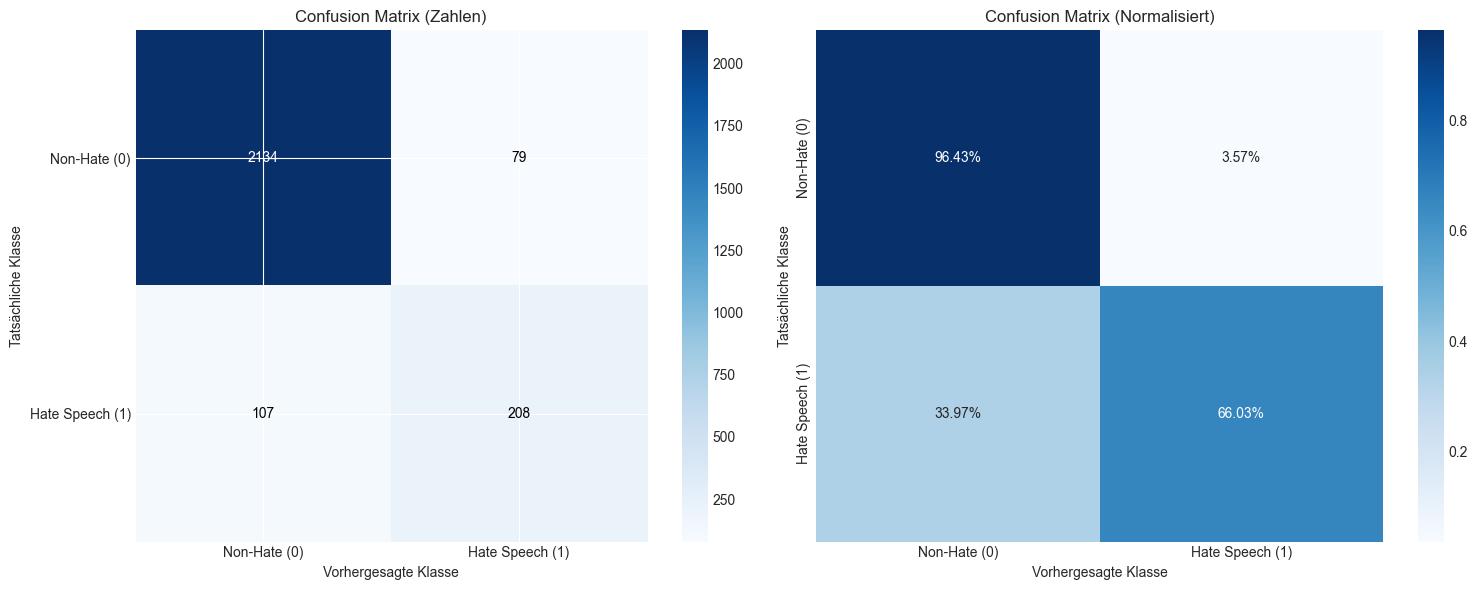


Confusion Matrix (Rohwerte):
                Predicted
                0      1
Actual  0     2134     79
        1      107    208

Confusion Matrix (Prozent):
                Predicted
                0      1
Actual  0     96.4%    3.6%
        1     34.0%   66.0%


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Erstelle zwei Visualisierungen: Zahlen und Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confusion Matrix mit Zahlen
ax1 = axes[0]
im1 = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.figure.colorbar(im1, ax=ax1)
ax1.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=['Non-Hate (0)', 'Hate Speech (1)'],
        yticklabels=['Non-Hate (0)', 'Hate Speech (1)'],
        title='Confusion Matrix (Zahlen)',
        ylabel='Tatsächliche Klasse',
        xlabel='Vorhergesagte Klasse')

# Füge Zahlen hinzu
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# 2. Confusion Matrix als Heatmap (normalisiert)
ax2 = axes[1]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=['Non-Hate (0)', 'Hate Speech (1)'],
            yticklabels=['Non-Hate (0)', 'Hate Speech (1)'])
ax2.set_title('Confusion Matrix (Normalisiert)')
ax2.set_ylabel('Tatsächliche Klasse')
ax2.set_xlabel('Vorhergesagte Klasse')

plt.tight_layout()
plt.show()

# Zeige Zahlen
print("\nConfusion Matrix (Rohwerte):")
print(f"                Predicted")
print(f"                0      1")
print(f"Actual  0    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"        1    {cm[1,0]:5d}  {cm[1,1]:5d}")

print(f"\nConfusion Matrix (Prozent):")
print(f"                Predicted")
print(f"                0      1")
print(f"Actual  0    {cm_normalized[0,0]*100:5.1f}%  {cm_normalized[0,1]*100:5.1f}%")
print(f"        1    {cm_normalized[1,0]*100:5.1f}%  {cm_normalized[1,1]*100:5.1f}%")


## 7. ROC Curve


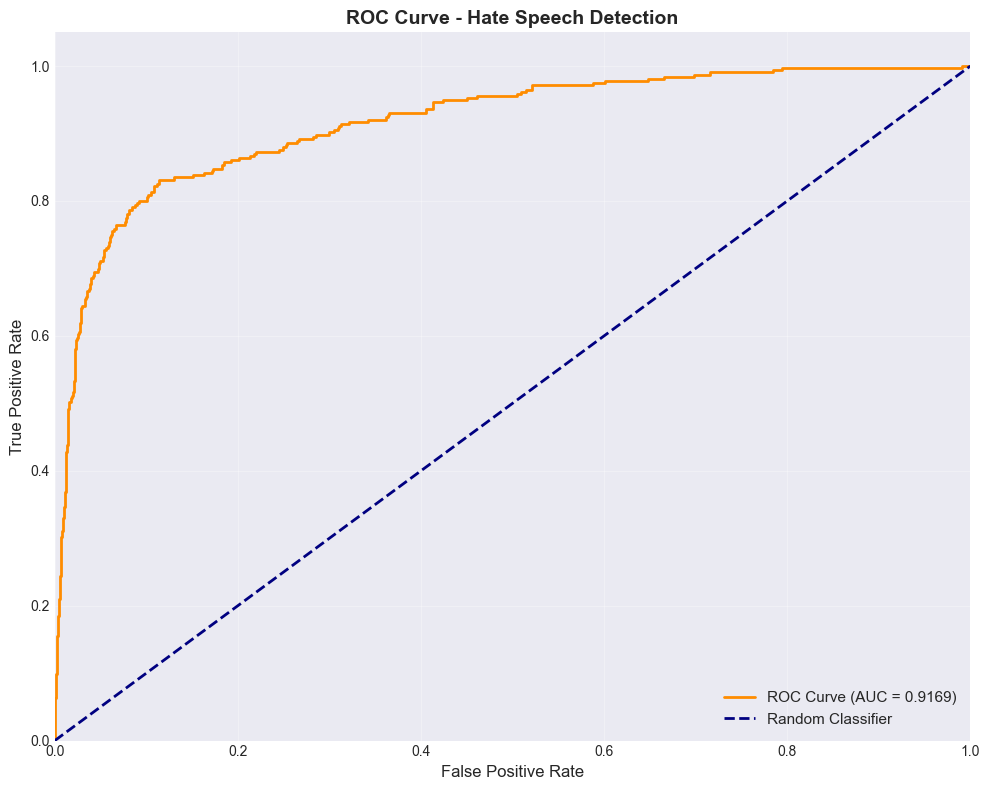

ROC AUC Score: 0.9169


In [9]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Hate Speech Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


## 8. Precision-Recall Curve


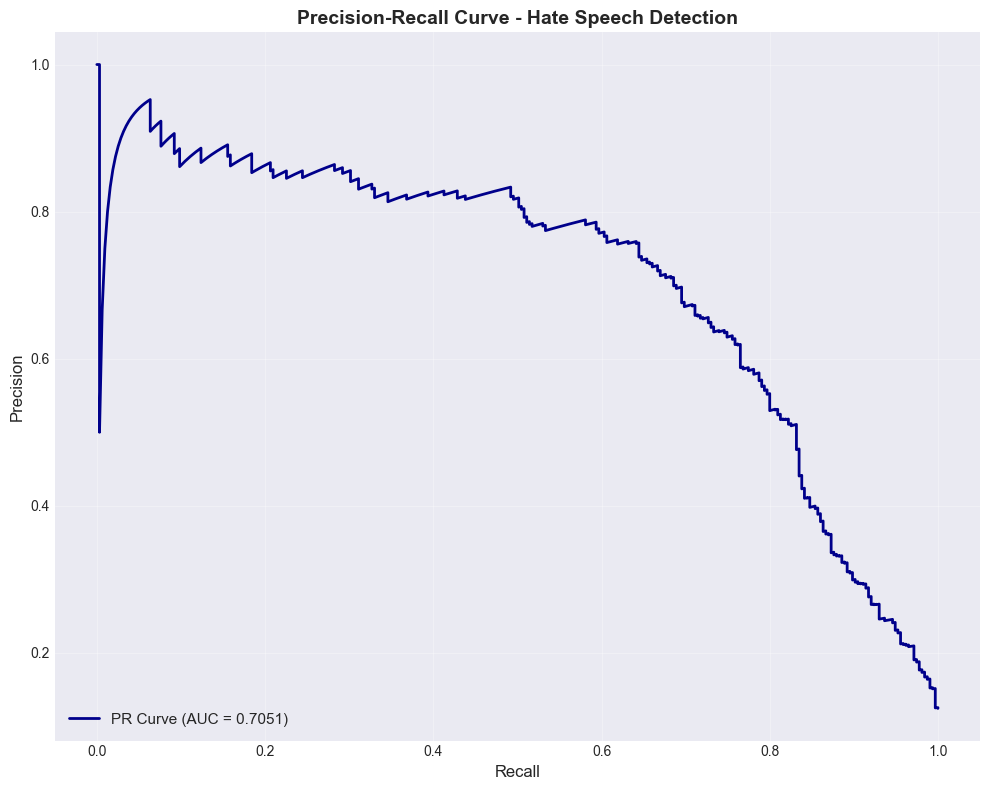

Precision-Recall AUC Score: 0.7051


In [10]:
# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob[:, 1])
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='darkblue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Hate Speech Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Precision-Recall AUC Score: {pr_auc:.4f}")


## 9. Metriken-Vergleich (Bar Chart)


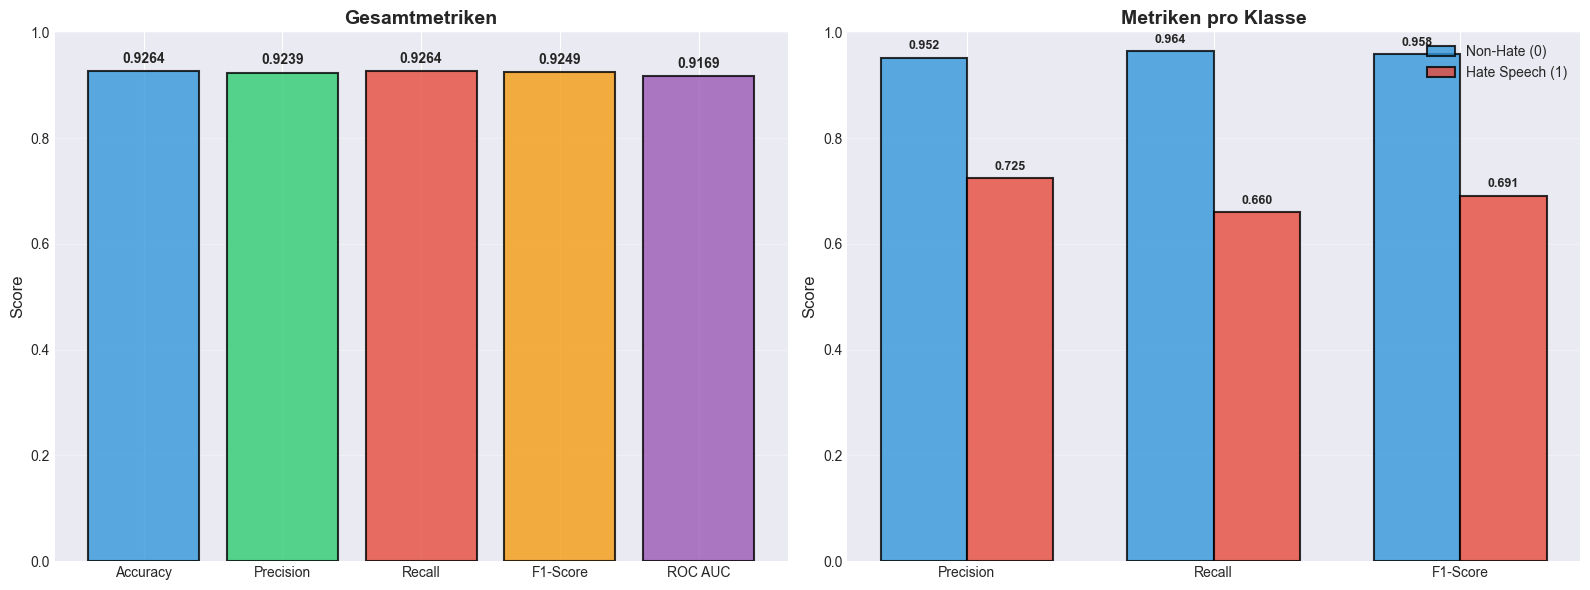

In [11]:
# Metriken-Vergleich
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Gesamtmetriken
ax1 = axes[0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Gesamtmetriken', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Füge Werte auf den Balken hinzu
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Metriken pro Klasse
ax2 = axes[1]
class_metrics = ['Precision', 'Recall', 'F1-Score']
class_0_values = [precision_0, recall_0, f1_0]
class_1_values = [precision_1, recall_1, f1_1]

x = np.arange(len(class_metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, class_0_values, width, label='Non-Hate (0)', 
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x + width/2, class_1_values, width, label='Hate Speech (1)', 
                color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Metriken pro Klasse', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(class_metrics)
ax2.legend()
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Füge Werte auf den Balken hinzu
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


## 10. Wahrscheinlichkeitsverteilung


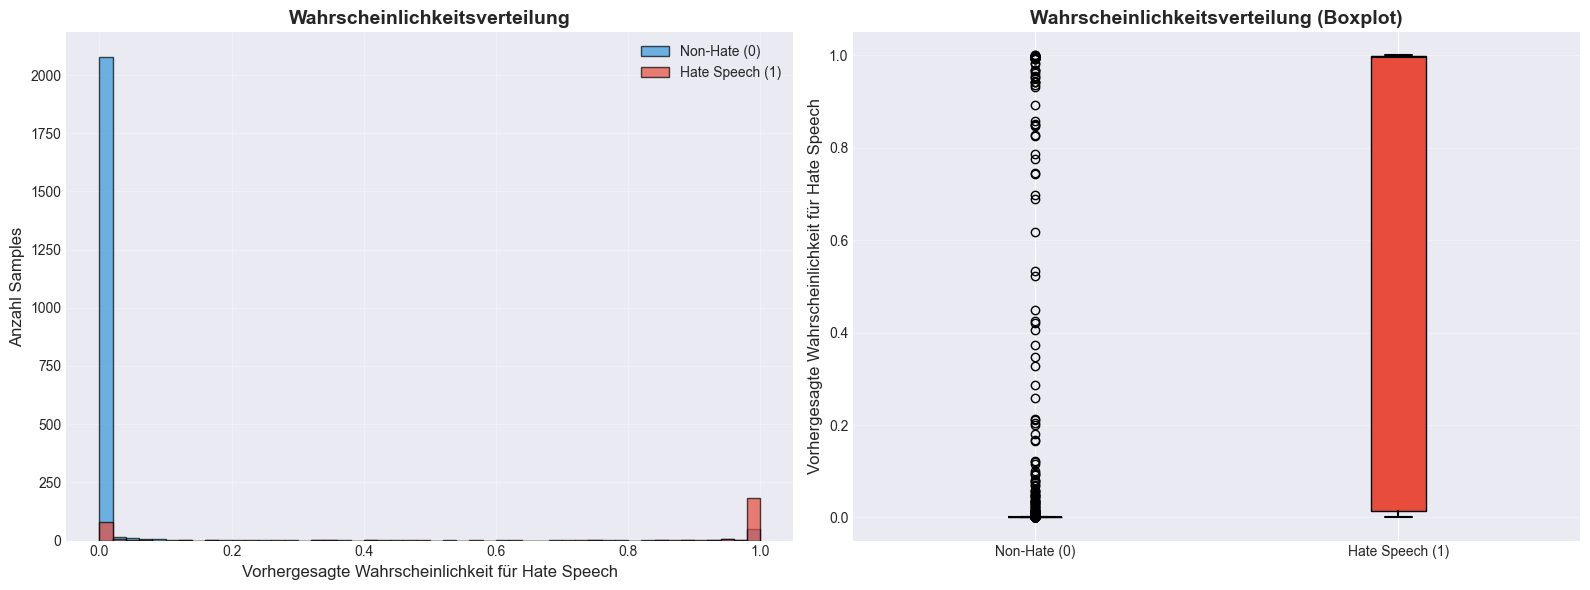

In [12]:
# Wahrscheinlichkeitsverteilung
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogramm der Wahrscheinlichkeiten
ax1 = axes[0]
ax1.hist(y_prob[y_true == 0, 1], bins=50, alpha=0.7, label='Non-Hate (0)', 
         color='#3498db', edgecolor='black')
ax1.hist(y_prob[y_true == 1, 1], bins=50, alpha=0.7, label='Hate Speech (1)', 
         color='#e74c3c', edgecolor='black')
ax1.set_xlabel('Vorhergesagte Wahrscheinlichkeit für Hate Speech', fontsize=12)
ax1.set_ylabel('Anzahl Samples', fontsize=12)
ax1.set_title('Wahrscheinlichkeitsverteilung', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Boxplot
ax2 = axes[1]
data_to_plot = [y_prob[y_true == 0, 1], y_prob[y_true == 1, 1]]
bp = ax2.boxplot(data_to_plot, labels=['Non-Hate (0)', 'Hate Speech (1)'], 
                 patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax2.set_ylabel('Vorhergesagte Wahrscheinlichkeit für Hate Speech', fontsize=12)
ax2.set_title('Wahrscheinlichkeitsverteilung (Boxplot)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Fehleranalyse


FEHLERANALYSE

❌ Falsch Positive (FP): 79
   (Als Hate Speech vorhergesagt, aber eigentlich Non-Hate)
   Durchschnittliche Wahrscheinlichkeit: 0.9408

❌ Falsch Negative (FN): 107
   (Als Non-Hate vorhergesagt, aber eigentlich Hate Speech)
   Durchschnittliche Wahrscheinlichkeit: 0.0383

✅ Korrekt klassifiziert: 2342 (92.64%)


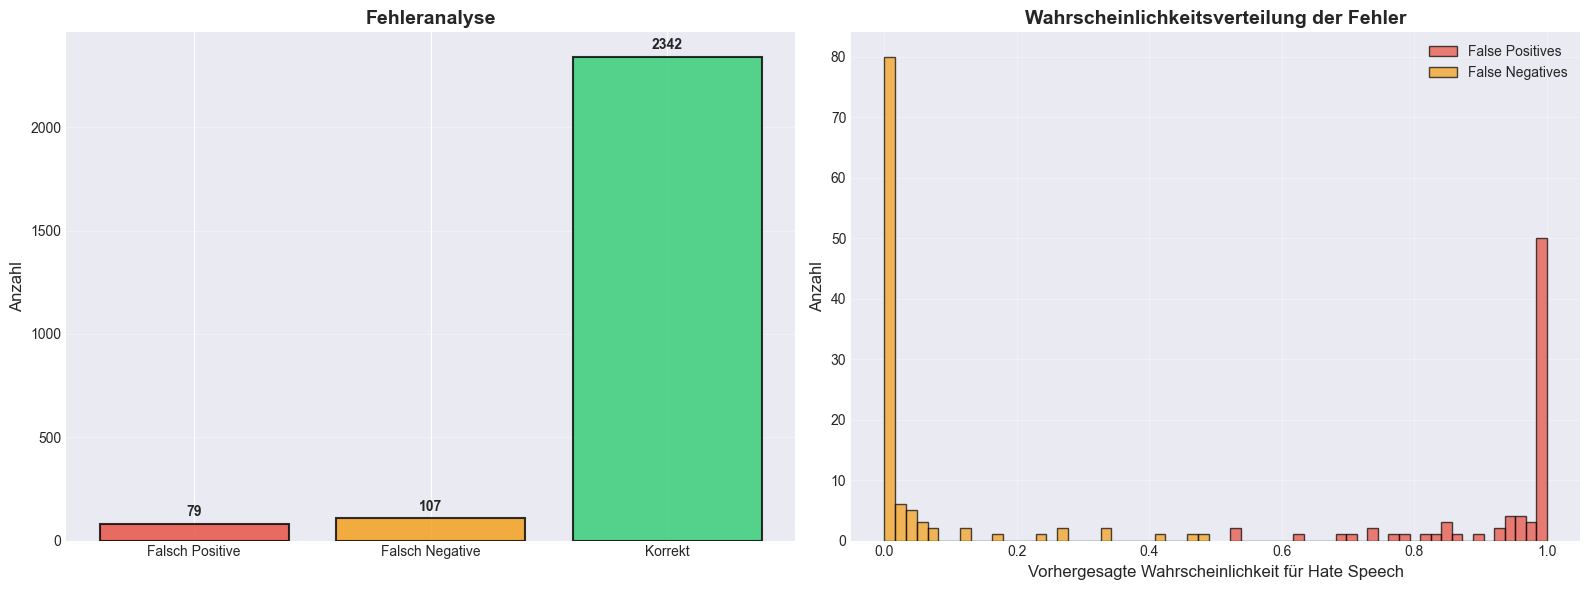


📝 Beispiele für Falsch Positive (erste 5):
   [0.995] Sie spricht von einer regelrechten "Trans-Mode". Keine Mode, sondern ein ganz natürliches Phänomen, ...
   [0.943] Twinkies sind ungesunde Snacks...
   [0.994] Immer dieses "Hast Du den zwei Meter Afrikaner gesehen? Der hat sicher 'nen riesigen..."... Man kann...
   [0.827] Ic h brauche kein Glasfaser , danke ....
   [0.999] Indigene Völker würden niemals versuchen, in den Weltraum zu fliegen, sie würden niemals versuchen, ...

📝 Beispiele für Falsch Negative (erste 5):
   [0.001] Die BILD schreibt: "Duschen und nach Hause gehen - WM-Aus für die Deutschen." Israel hat gar nicht e...
   [0.000] Merkel ist psycho:(...
   [0.036] Wobei wir aufpassen müssen weil die großkopferten das Bargeld abschaffen wollen wen wir nur noch mit...
   [0.489] Deutsch-Albaner, Schweden-Araber......schon interessant welche Nationalitäten hier im Zuge der polit...
   [0.001] die UN wird vom Vatikan diktiert! Was erwartet ihr, für diese Spiner gibt es nur

In [13]:
# Fehleranalyse
errors = val_df.copy()
errors['pred'] = y_pred
errors['prob_hate'] = y_prob[:, 1]
errors['correct'] = (errors['labels'] == errors['pred'])

# Falsch Positive (als Hate Speech vorhergesagt, aber eigentlich Non-Hate)
false_positives = errors[(errors['labels'] == 0) & (errors['pred'] == 1)]
# Falsch Negative (als Non-Hate vorhergesagt, aber eigentlich Hate Speech)
false_negatives = errors[(errors['labels'] == 1) & (errors['pred'] == 0)]

print("="*60)
print("FEHLERANALYSE")
print("="*60)
print(f"\n❌ Falsch Positive (FP): {len(false_positives)}")
print(f"   (Als Hate Speech vorhergesagt, aber eigentlich Non-Hate)")
print(f"   Durchschnittliche Wahrscheinlichkeit: {false_positives['prob_hate'].mean():.4f}")

print(f"\n❌ Falsch Negative (FN): {len(false_negatives)}")
print(f"   (Als Non-Hate vorhergesagt, aber eigentlich Hate Speech)")
print(f"   Durchschnittliche Wahrscheinlichkeit: {false_negatives['prob_hate'].mean():.4f}")

print(f"\n✅ Korrekt klassifiziert: {errors['correct'].sum()} ({errors['correct'].mean()*100:.2f}%)")

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Fehlertypen
ax1 = axes[0]
error_types = ['Falsch Positive', 'Falsch Negative', 'Korrekt']
error_counts = [len(false_positives), len(false_negatives), errors['correct'].sum()]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

bars = ax1.bar(error_types, error_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Anzahl', fontsize=12)
ax1.set_title('Fehleranalyse', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(error_counts)*0.01,
            f'{count}', ha='center', va='bottom', fontweight='bold')

# 2. Wahrscheinlichkeitsverteilung für Fehler
ax2 = axes[1]
if len(false_positives) > 0:
    ax2.hist(false_positives['prob_hate'], bins=30, alpha=0.7, label='False Positives', 
             color='#e74c3c', edgecolor='black')
if len(false_negatives) > 0:
    ax2.hist(false_negatives['prob_hate'], bins=30, alpha=0.7, label='False Negatives', 
             color='#f39c12', edgecolor='black')
ax2.set_xlabel('Vorhergesagte Wahrscheinlichkeit für Hate Speech', fontsize=12)
ax2.set_ylabel('Anzahl', fontsize=12)
ax2.set_title('Wahrscheinlichkeitsverteilung der Fehler', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Zeige einige Beispiele
if len(false_positives) > 0:
    print(f"\n📝 Beispiele für Falsch Positive (erste 5):")
    for idx, row in false_positives.head(5).iterrows():
        print(f"   [{row['prob_hate']:.3f}] {row['text'][:100]}...")

if len(false_negatives) > 0:
    print(f"\n📝 Beispiele für Falsch Negative (erste 5):")
    for idx, row in false_negatives.head(5).iterrows():
        print(f"   [{row['prob_hate']:.3f}] {row['text'][:100]}...")


## 12. Zusammenfassung und Export


In [14]:
# Erstelle Zusammenfassung
summary = {
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)', 
               'ROC AUC', 'PR AUC',
               'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)',
               'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
    'Value': [accuracy, precision, recall, f1, roc_auc, pr_auc,
              precision_0, recall_0, f1_0, precision_1, recall_1, f1_1]
}

summary_df = pd.DataFrame(summary)
print("="*60)
print("ZUSAMMENFASSUNG DER VALIDIERUNG")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

# Exportiere Ergebnisse
output_dir = Path("validation_results")
output_dir.mkdir(exist_ok=True)

# Speichere Zusammenfassung
summary_df.to_csv(output_dir / "validation_summary.csv", index=False, encoding="utf-8-sig")

# Speichere detaillierte Ergebnisse
errors['prob_hate'] = y_prob[:, 1]
errors.to_csv(output_dir / "validation_predictions.csv", index=False, encoding="utf-8-sig")

# Speichere Fehlerbeispiele
if len(false_positives) > 0:
    false_positives.to_csv(output_dir / "false_positives.csv", index=False, encoding="utf-8-sig")
if len(false_negatives) > 0:
    false_negatives.to_csv(output_dir / "false_negatives.csv", index=False, encoding="utf-8-sig")

print(f"\n✅ Ergebnisse exportiert nach: {output_dir}")
print(f"   - validation_summary.csv")
print(f"   - validation_predictions.csv")
if len(false_positives) > 0:
    print(f"   - false_positives.csv")
if len(false_negatives) > 0:
    print(f"   - false_negatives.csv")


ZUSAMMENFASSUNG DER VALIDIERUNG
              Metric    Value
            Accuracy 0.926424
Precision (Weighted) 0.923904
   Recall (Weighted) 0.926424
 F1-Score (Weighted) 0.924944
             ROC AUC 0.916855
              PR AUC 0.705116
 Precision (Class 0) 0.952253
    Recall (Class 0) 0.964302
  F1-Score (Class 0) 0.958240
 Precision (Class 1) 0.724739
    Recall (Class 1) 0.660317
  F1-Score (Class 1) 0.691030

✅ Ergebnisse exportiert nach: validation_results
   - validation_summary.csv
   - validation_predictions.csv
   - false_positives.csv
   - false_negatives.csv
